In [1]:
# Imports
import os 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import pandas as pd
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as ad

In [ ]:
!mkdir data

In [12]:
!tar -xf data/GSE235063_RAW.tar

In [2]:
files = os.listdir('data')

In [ ]:
# Sanity Check
print(files)

In [43]:
# Filtering for only feature dataset
ffs = [x for x in files if 'feature' in x]

In [44]:
!mkdir temp

mkdir: cannot create directory ‘temp’: File exists


In [45]:
# Opening files w/ Gzip + labeling with Gene Expression
for ff in ffs:
    with gzip.open('data/' + ff, 'rt') as f_in:
        with gzip.open('temp/' + ff , 'wt') as f_out:
            for line in f_in:
                f_out.write(line.strip() + "\tGene Expression\n")

In [46]:
!zcat temp/GSM7494269_AML3_DX_raw_features.tsv.gz | head

ENSG00000243485	MIR1302-2HG	Gene Expression	Gene Expression
ENSG00000237613	FAM138A	Gene Expression	Gene Expression
ENSG00000186092	OR4F5	Gene Expression	Gene Expression
ENSG00000238009	AL627309.1	Gene Expression	Gene Expression
ENSG00000239945	AL627309.3	Gene Expression	Gene Expression
ENSG00000239906	AL627309.2	Gene Expression	Gene Expression
ENSG00000241599	AL627309.4	Gene Expression	Gene Expression
ENSG00000236601	AL732372.1	Gene Expression	Gene Expression
ENSG00000284733	OR4F29	Gene Expression	Gene Expression
ENSG00000235146	AC114498.1	Gene Expression	Gene Expression

gzip: stdout: Broken pipe


In [47]:
!mv temp/* data/

In [48]:
# Forming .h5 files w/ Scanpy
sc.read_10x_mtx('data/', prefix = 'GSM7494269_AML3_DX_raw_')

AnnData object with n_obs × n_vars = 6794880 × 33538
    var: 'gene_ids', 'feature_types'

In [ ]:
!mkdir raw_data

In [51]:
# Forming h5ad files for cell bender 
for prefix in set([x.split('_raw')[0] + '_raw_' for x in files if 'processed' not in x and 'tar' not in x]):
    adata = sc.read_10x_mtx('data/', prefix = prefix)
    adata.write_h5ad('raw_adata/' + prefix + '.h5ad')

#### Removing Ambient RNA w/ CellBender 

In [5]:
# Ran below in terminal to remove ambient RNA on all samples
# for file in *h5ad; do cellbender remove-background 
# --input $file
# --output ../clean_adata/$(basename $file .h5ad)denoised
# --total-droplets-included 50000 
# --cuda; done

In [5]:
metrics = []
for file in [x for x in os.listdir('clean_adata/') if x.endswith('metrics.csv')]:
    _ = pd.read_csv('clean_adata/' + file,
                header = None, names = ['Metric', 'Value']).set_index('Metric').T

    _['File'] = file
    metrics.append(_)
    
metrics = pd.concat(metrics).reset_index()

In [6]:
# Tabular data of Ambient RNA Removal 
metrics

Metric,index,total_raw_counts,total_output_counts,total_counts_removed,fraction_counts_removed,total_raw_counts_in_cells,total_counts_removed_from_cells,fraction_counts_removed_from_cells,average_counts_removed_per_cell,target_fpr,expected_cells,found_cells,output_average_counts_per_cell,ratio_of_found_cells_to_expected_cells,found_empties,fraction_of_analyzed_droplets_that_are_nonempty,convergence_indicator,overall_change_in_train_elbo,File
0,Value,72182448.0,70205515.0,1976933.0,0.027,72182440.0,1976925.0,0.027,158.458,0.01,4254.0,12476.0,5627.246,2.933,37524.0,0.250,0.679,1141.909,GSM7494257_AML16_DX_raw_denoised_metrics.csv
1,Value,50634272.0,48952803.0,1681469.0,0.033,50634240.0,1681437.0,0.033,124.477,0.01,4754.0,13508.0,3623.986,2.841,36492.0,0.270,0.382,1152.159,GSM7494258_AML16_REL_raw_denoised_metrics.csv
2,Value,40809892.0,39999732.0,810160.0,0.020,40809884.0,810152.0,0.020,88.648,0.01,3227.0,9139.0,4376.817,2.832,40861.0,0.183,0.806,660.301,GSM7494259_AML16_REM_raw_denoised_metrics.csv
3,Value,57705552.0,56276789.0,1428763.0,0.025,57705520.0,1428731.0,0.025,134.951,0.01,4136.0,10587.0,5315.650,2.560,39413.0,0.212,0.638,947.085,GSM7494260_AML6_DX_raw_denoised_metrics.csv
4,Value,61326800.0,60213015.0,1113785.0,0.018,61326812.0,1113797.0,0.018,128.008,0.01,3044.0,8701.0,6920.241,2.858,41299.0,0.174,0.537,948.167,GSM7494261_AML6_REL_raw_denoised_metrics.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,Value,64239220.0,62833320.0,1405900.0,0.022,64239220.0,1405900.0,0.022,165.478,0.01,2519.0,8496.0,7395.636,3.373,41504.0,0.170,0.935,954.965,GSM7494327_AML12_REL_raw_denoised_metrics.csv
71,Value,30097408.0,29139860.0,957548.0,0.032,30097436.0,957576.0,0.032,66.300,0.01,2020.0,14443.0,2017.577,7.150,35557.0,0.289,1.551,619.214,GSM7494328_AML12_REM_raw_denoised_metrics.csv
72,Value,38003192.0,36728393.0,1274799.0,0.034,38003184.0,1274791.0,0.034,134.259,0.01,2870.0,9495.0,3868.183,3.308,40505.0,0.190,0.545,724.789,GSM7494329_AML13_DX_addenoised_metrics.csv
73,Value,75560208.0,74360971.0,1199237.0,0.016,75560176.0,1199205.0,0.016,115.966,0.01,3954.0,10341.0,7190.888,2.615,39659.0,0.207,0.437,1999.695,GSM7494330_AML13_REL_raw_denoised_metrics.csv


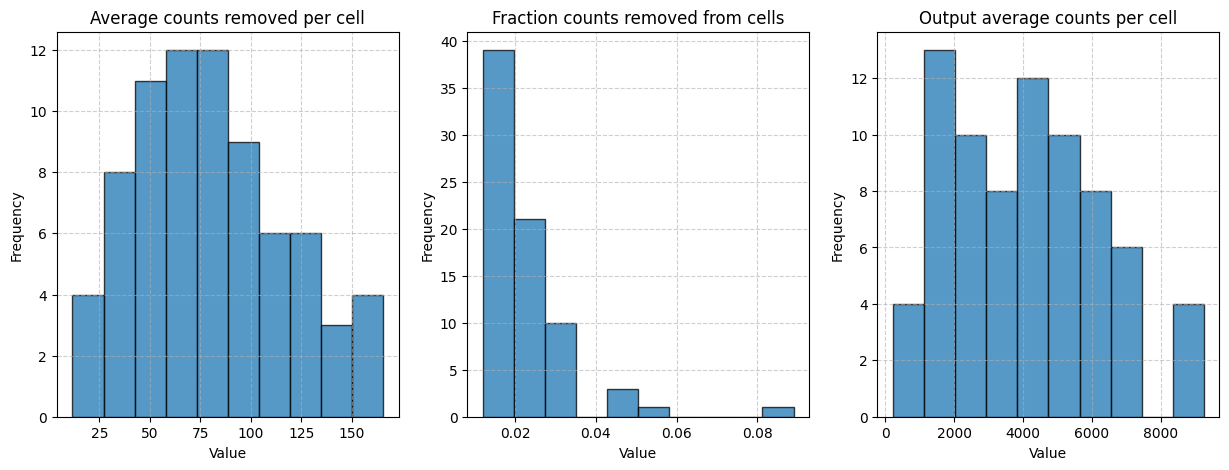

In [4]:
# Define the columns to plot
columns = ["average_counts_removed_per_cell", "fraction_counts_removed_from_cells", "output_average_counts_per_cell"]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the columns and create a histogram for each
for ax, column in zip(axes, columns):
    ax.hist(metrics[column], edgecolor='black', alpha=0.75)
    ax.set_title(column.replace("_", " ").capitalize(), fontsize=12)
    ax.set_xlabel("Value", fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

We can generally see the fraction count removals are concentrated at ~0.03 and lower with very few samples above and the highest being at 0.08 which may potentially be an outlier, with an average counts close to ~75 counts. 

### Quality Control

In [7]:
# Loading in the processed files from CellBender
adatas = [x for x in os.listdir('clean_adata/') if x.endswith('filtered.h5')]

In [8]:
def load_it(adata):
    ''' Function to load in Cell Data and transform to AnnData Object to track Patient#, Diagnosis, Barcode#'''
    samp = adata.split('_')[1]
    dx = adata.split('_')[2]
    adata = sc.read_10x_h5('clean_adata/' + adata)
    adata.obs['Patient'] = samp
    adata.obs['DX'] = dx
    adata.obs['Sample'] = adata.obs['Patient'] + '_' + adata.obs['DX']
    adata.obs.index = adata.obs.index + '-' + samp + '_' + dx
    return adata

In [9]:
adatas = [load_it(ad) for ad in adatas]

In [10]:
# Sannity check to make sure all samples loaded in 
len(adatas)

75

In [11]:
# Removing low UMI count samples that CellBender might not have caught with Scanpy
def qc(adata):
    sc.pp.filter_cells(adata, min_genes = 200)

    # Booleans for Cell-Type
    adata.var["mt"] = adata.var_names.str.startswith("MT-")     #  Adding Boolean for Mitochondrial
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))     # Adding Boolean for Ribosomal Data
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))     # Adding a Boolean for Hemoglobin 

    # Calculating QC Metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True) 

    # Listing unnecessary columns
    remove = ['total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 
          'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb']

    # Redefining to exclude unnecessary columns
    adata.obs = adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [12]:
# QC'ing the actual annotated data
adatas = [qc(ad) for ad in adatas]

In [13]:
adatas

[AnnData object with n_obs × n_vars = 8148 × 33538
     obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 AnnData object with n_obs × n_vars = 6361 × 33538
     obs: 'Patient', 'DX', 'Sample', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
 AnnData object with n_obs × n_vars = 6008 × 33538
     obs: 'Patient', 'DX', 'Sample', 

In [14]:
# Converting the AnnData object to a DF for further analysis
df = pd.concat([x.obs for x in adatas])
df = df.sort_values('Sample') #Sort by Sample

In [15]:
df

,Patient,DX,Sample,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,pct_counts_mt,pct_counts_ribo,pct_counts_hb
ACTGTCCCACAATGTC-1-AML10_DX,AML10,DX,AML10_DX,5458,5458,8.605021,34943.0,10.461502,16.366654,6.150016,24.064906,0.008585
GTTCGCTGTTCTCACC-1-AML10_DX,AML10,DX,AML10_DX,1771,1771,7.479864,4322.0,8.371705,37.135585,30.032392,8.954188,0.000000
CTGTAGAAGAGAGCAA-1-AML10_DX,AML10,DX,AML10_DX,2066,2066,7.633854,4368.0,8.382289,33.264652,27.403846,4.143773,0.000000
AGACACTGTGGTCCCA-1-AML10_DX,AML10,DX,AML10_DX,1785,1785,7.487734,4386.0,8.386401,19.881441,6.064751,15.982672,0.022800
TTGGTTTAGGAACTCG-1-AML10_DX,AML10,DX,AML10_DX,1849,1849,7.522941,4397.0,8.388905,19.877189,9.938594,17.489197,0.045486
...,...,...,...,...,...,...,...,...,...,...,...,...
AGAAGCGTCTGAGCAT-1-AML9_REM,AML9,REM,AML9_REM,1113,1113,7.015712,3876.0,8.262817,26.393189,6.630547,41.486068,0.025800
CTCTGGTCATAGAATG-1-AML9_REM,AML9,REM,AML9_REM,1389,1389,7.237059,3844.0,8.254529,25.156087,9.157128,28.069719,0.000000
TCCTAATTCACCGGGT-1-AML9_REM,AML9,REM,AML9_REM,1337,1337,7.198931,3875.0,8.262559,29.909677,13.135484,30.270968,0.000000
TGGATGTAGTGGCAGT-1-AML9_REM,AML9,REM,AML9_REM,1110,1110,7.013016,3858.0,8.258163,27.164334,9.434940,42.120270,0.000000


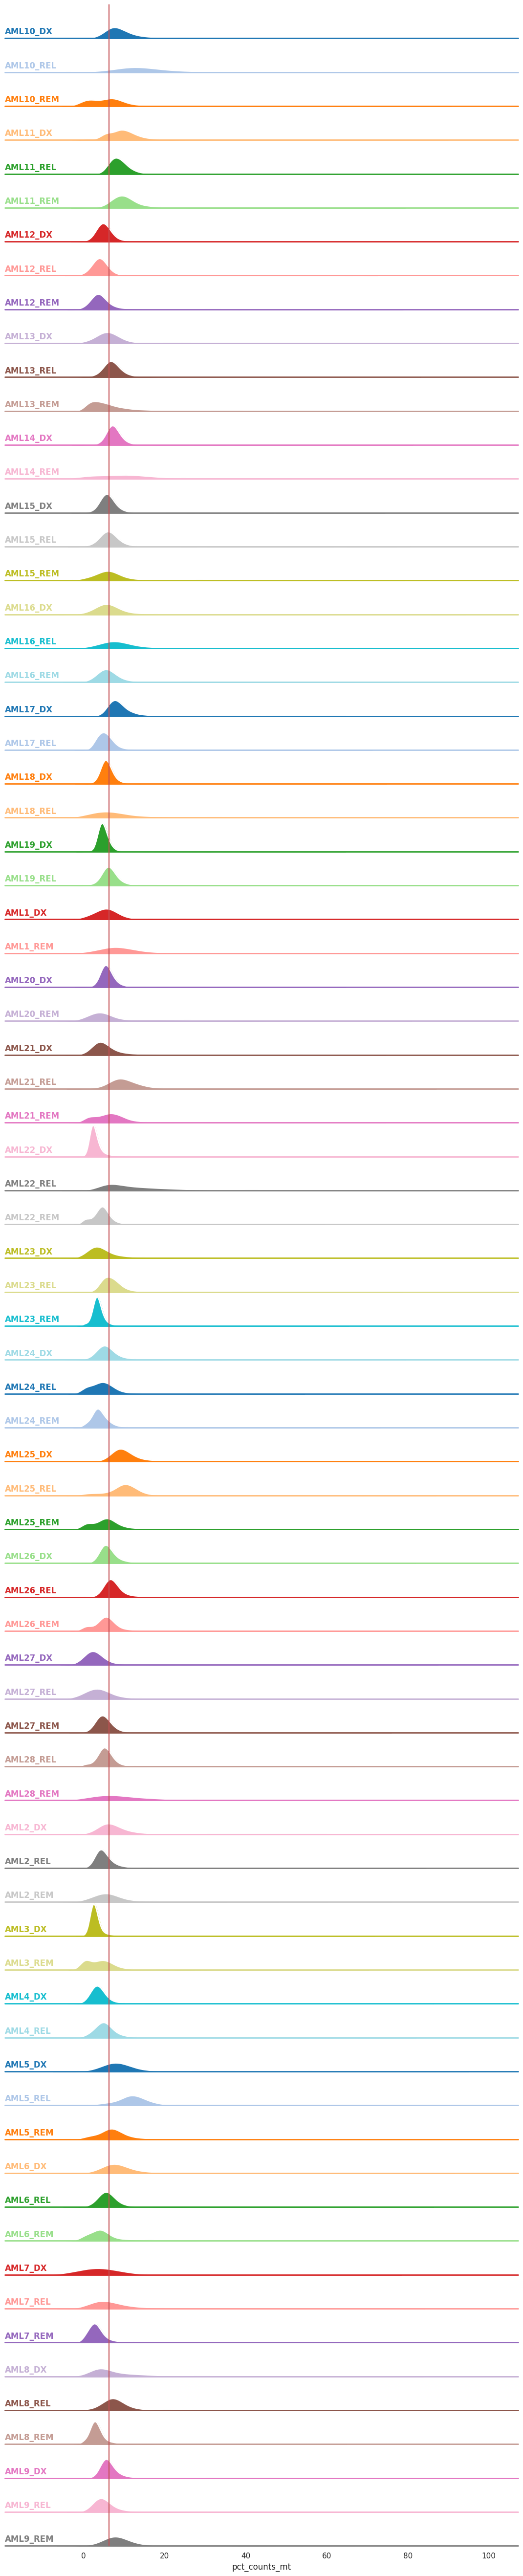

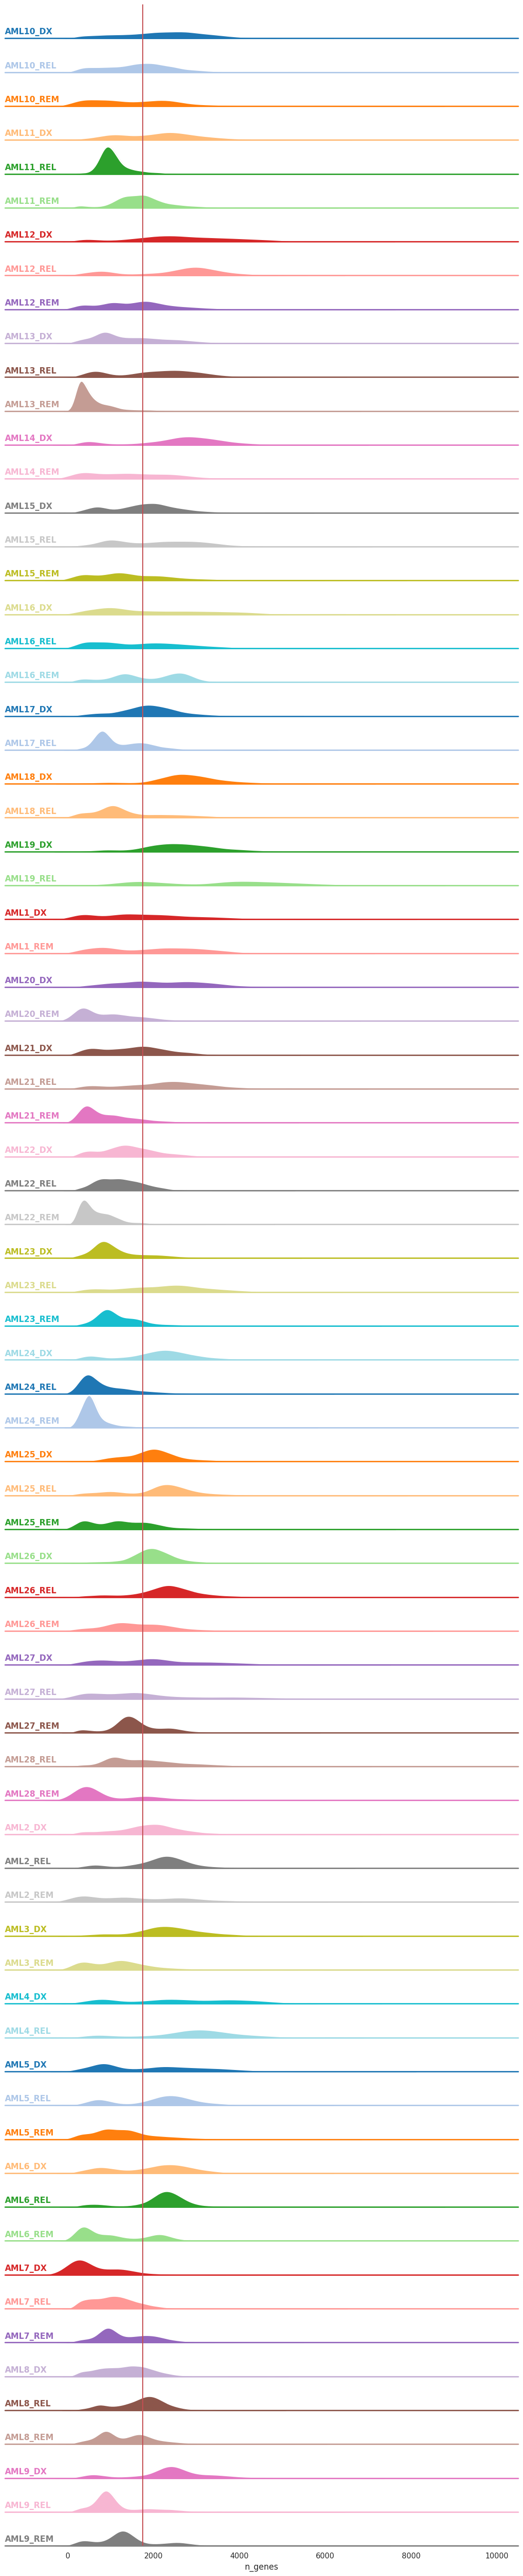

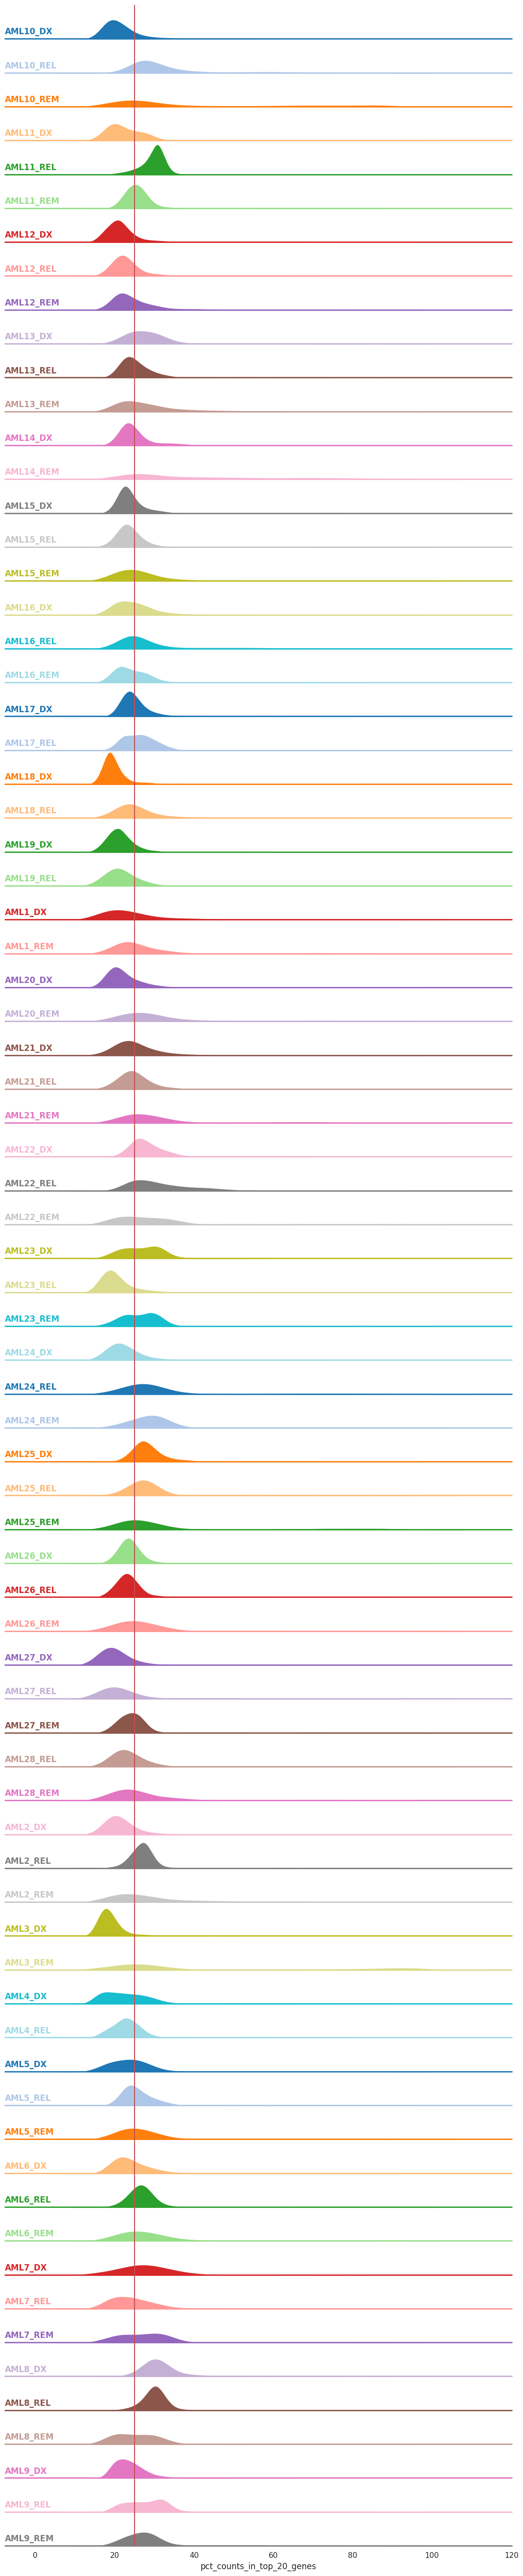

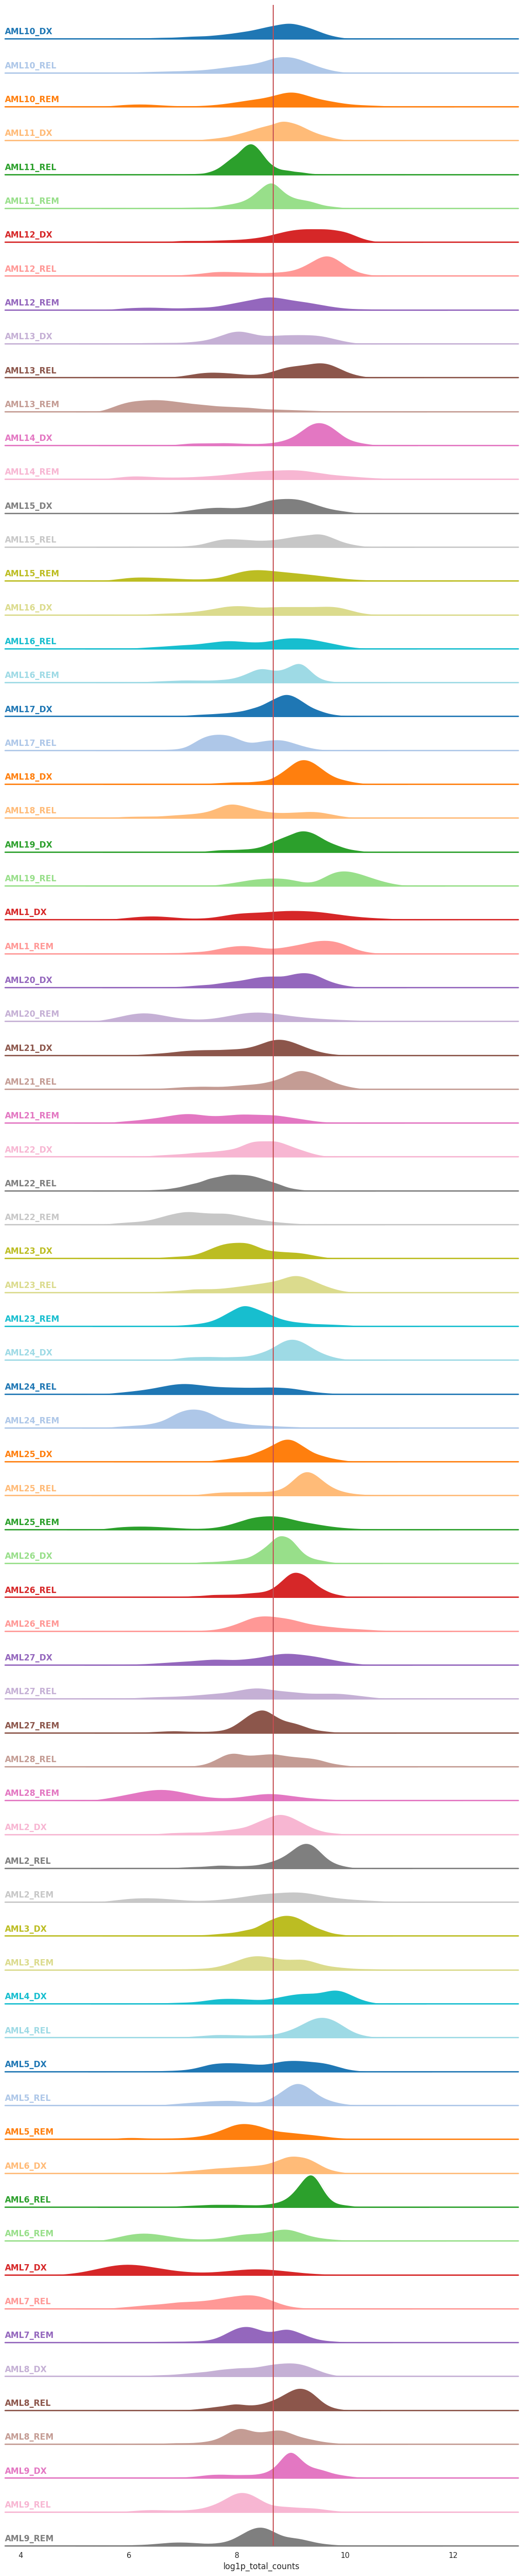

In [16]:
# Define all variables to be plotted
values = ["pct_counts_mt", "n_genes", "pct_counts_in_top_20_genes", "log1p_total_counts"]

# Ensuring transparent background + white background
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Iterate over each variable and create separate FacetGrid plots
for value in values:
    g = sns.FacetGrid(df, row="Sample", hue="Sample", aspect=15, height=0.7, palette="tab20", despine=False)

    # Kernal Density Estimation curves for each + hoirzontal line at y=0
    g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    
    # Function to add sample labels
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    
    g.map(label, value)

    # Remove excessive spacing and titles
    g.figure.subplots_adjust(hspace=-0.4)  # Less negative spacing to avoid tight_layout issues
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    
    # Add vertical median line for each sample
    for ax in g.axes.flat:
        ax.axvline(x=df[value].median(), color='r', linestyle='-')

    # **Disable automatic tight layout**
    g.figure.tight_layout(pad=0, h_pad=0, w_pad=0)

    plt.show()  # Show each plot separately to avoid layout conflicts


Looking at the distributions we can see:
For percent mitochondrial counts we see some variation, but no large outliter, all near 0-20% max. 
For the number of genes we can see multi-modal distributions emerge (filtering will likely take care of it), some general variation between samples, but generally around ~2000.
When looking at the percent count in of the top 20 genes, we see some variation, but again some multi-modal distributions like in AML14.

## Doublet Removal

In [17]:
# Outlier detection via Mean Absolute Deviation 
def mean_abs_dev_outlier(adata, metric, nmads, upper_only=False):
    '''
    Detect outliers in the specified metric of an AnnData object based on 
    the Median Absolute Deviation (MAD) method.

    Parameters:
    -----------
    adata : AnnData
        The AnnData object containing the data.
    metric : str
        The column name from adata.obs to evaluate for outliers.
    nmads : float
        The number of MADs from the median to define the threshold for outliers.
    upper_only : bool, optional, default=False
        If True, only upper outliers (values greater than the threshold) are detected.
        If False, both lower and upper outliers are detected.

    '''
    M = adata.obs[metric]  # Extracting metric values from adata

    # Boolean mask filtering for lower + upper outlier
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))

    return M > np.median(M) + nmads * mad(M)


In [18]:
# Boost Classifier for doublet detection 
clf = doubletdetection.BoostClassifier(
    n_iters=10,
    clustering_algorithm="louvain",
    standard_scaling=True,
    pseudocount=0.1,
    n_jobs=-1
)

In [23]:
def pre_proc_batch(adata_batch, clf):
    # Filter based on MT % count (likely low quality / stressed)
    adata_batch = adata_batch[adata_batch.obs.pct_counts_mt < 25]

    # Boolean Vector to filter outliers based on features
    bool_vector = mean_abs_dev_outlier(adata_batch, 'log1p_total_counts', 5) +\
                  mean_abs_dev_outlier(adata_batch, 'log1p_n_genes_by_counts', 5) +\
                  mean_abs_dev_outlier(adata_batch, 'pct_counts_in_top_20_genes', 5) +\
                  mean_abs_dev_outlier(adata_batch, 'pct_counts_mt', 3, upper_only=True)
    adata_batch = adata_batch[~bool_vector]

    # Tracking cells removed
    adata_batch.uns['cells_removed'] = sum(bool_vector)

    # Doublets detection
    doublets = clf.fit(adata_batch.X).predict(p_thresh=1e-3, voter_thresh=0.5)
    doublet_score = clf.doublet_score()

    # Store results from doublet scoring
    adata_batch.obs["doublet"] = doublets
    adata_batch.obs["doublet_score"] = doublet_score

    # Remove doublets
    adata_batch.uns['doublets_removed'] = adata_batch.obs.doublet.sum()
    adata_batch = adata_batch[adata_batch.obs.doublet == 0]

    return adata_batch

In [24]:
import os

def pre_proc_in_batches(adatas, clf, batch_size=10, output_dir='processed_batches'):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get the list of already saved files
    saved_files = [f for f in os.listdir(output_dir) if f.endswith('.h5')]
    # Extract the index numbers of saved files
    saved_indexes = [int(f.split('_')[-1].split('.')[0]) for f in saved_files]

    # Determine the starting index for the batch to continue from
    start_index = max(saved_indexes, default=0)  # Start from the highest saved index + 1
    print(f"Resuming from batch {start_index + 1}")

    # Process the batches starting from the next unsaved batch
    for i, ad in enumerate(adatas[start_index:], start=start_index + 1):
        # Process the batch
        processed_adata = pre_proc_batch(ad, clf)

        # Save the processed AnnData object as an .h5 file
        file_name = os.path.join(output_dir, f"processed_batch_{i}.h5")
        processed_adata.write(file_name)

        # Clear the processed data from memory immediately after saving
        del processed_adata

        # Optionally print progress to monitor the process
        if (i + 1) % 10 == 0:
            print(f"Processed and saved {i + 1}/{len(adatas)} batches.")

    # Optionally clear the original adatas list from memory if not needed anymore
    del adatas


In [25]:
# Warning just to silence scikit future warning from CLF, other warning just from not using .copy on adata but not enough memory for that
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
!mkdir processed_batches

In [ ]:
output_dir = 'processed_batches'  # Directory where processed files will be saved
batch_size = 10  # Define the batch size if needed (default is 10)
processed_adatas = pre_proc_in_batches(adatas, clf, batch_size, output_dir)

In [2]:
# Function to merge the batched h5 files
def merge_h5_files(input_dir, output_file):
    # List all .h5 files in the input directory
    h5_files = [f for f in os.listdir(input_dir) if f.endswith('.h5')]
    h5_files.sort()  # Ensure the order of files is correct, if needed

    # Initialize an empty list to store AnnData objects
    adatas = []

    # Load each .h5 file as an AnnData object
    for h5_file in h5_files:
        adata = ad.read(os.path.join(input_dir, h5_file))
        adatas.append(adata)

    # Concatenate all AnnData objects into one
    combined_adata = ad.concat(adatas, axis=0)  # axis=0 combines along the cells

    # Save the combined AnnData object as a new .h5 file
    combined_adata.write(output_file)
    print(f"Merged {len(h5_files)} files into {output_file}")

In [ ]:
input_dir = 'processed_batches'  
output_file = 'merged_data.h5' 

merge_h5_files(input_dir, output_file)